In [102]:
import pandas as pd
import yfinance as yf
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from pandas_datareader import data as web
import datetime as dt
from scipy import stats
import 

Visualization And Analysis

In [51]:
ticker = "^GSPC"              #SP500 code in yfinance
start = "1927-12-30"
end = None                    #None = until today
outfile_all = "sp500_daily_all.csv" #file with all information includes Open/High/Low/Close/Adj Close/Volume
outfile_close = "sp500_daily_close.csv" #Only date information and closing price

In [52]:
df = yf.download(ticker, start=start, end=end, interval="1d", progress=False) #Downloading the data in 'days'

C:\Users\admin\AppData\Local\Temp\ipykernel_26760\710224635.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, interval="1d", progress=False) #Downloading the data in 'days'


In [54]:
#df.to_csv(outfile_all, index=True)
#df_close = df[["Close"]].copy()
#df_close.to_csv(outfile_close, index=True)

In [7]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,0
1928-01-03,17.760000,17.760000,17.760000,17.760000,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,0
1928-01-06,17.660000,17.660000,17.660000,17.660000,0


In [8]:
df_close.head()

Price,Close
Ticker,^GSPC
Date,
1927-12-30,17.660000
1928-01-03,17.760000
1928-01-04,17.719999
1928-01-05,17.549999
1928-01-06,17.660000


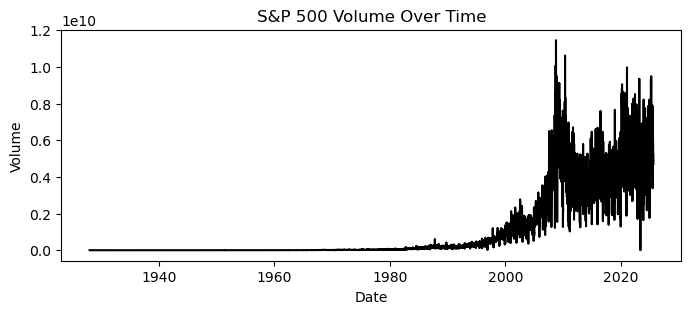

In [20]:
plt.figure(figsize=(8,3))
plt.plot(df.index, df['Volume'], color='black')
plt.title('S&P 500 Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

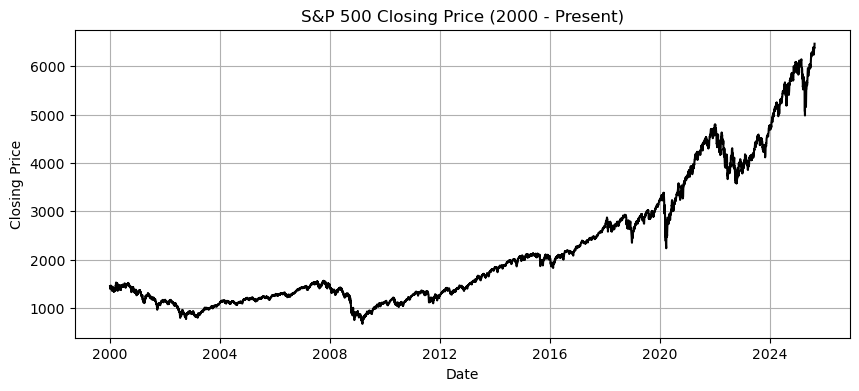

In [21]:
#Data after year 2000
df_close_2000 = df_close.loc["2000-01-01":]

#Closing price over time
plt.figure(figsize=(10,4))
plt.plot(df_close_2000.index, df_close_2000[('Close', '^GSPC')], color='black')
plt.title('S&P 500 Closing Price (2000 - Present)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()


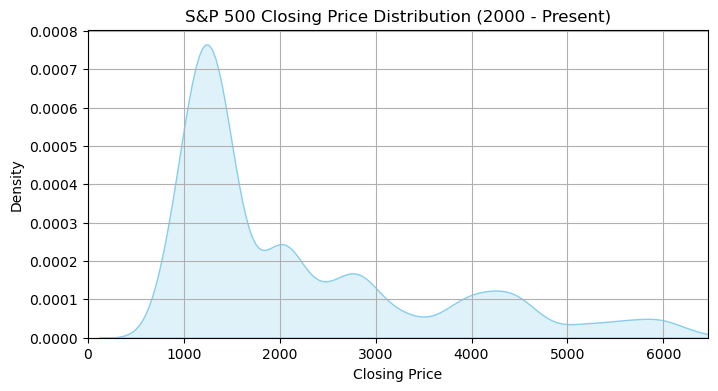

In [24]:
closing_prices = df_close_2000[('Close', '^GSPC')]

plt.figure(figsize=(8,4))
sns.kdeplot(closing_prices, fill=True, color='skyblue', bw_adjust=0.8)
plt.title("S&P 500 Closing Price Distribution (2000 - Present)")
plt.xlabel("Closing Price")
plt.ylabel("Density")
plt.xlim(0, closing_prices.max())
plt.grid(True)
plt.show()

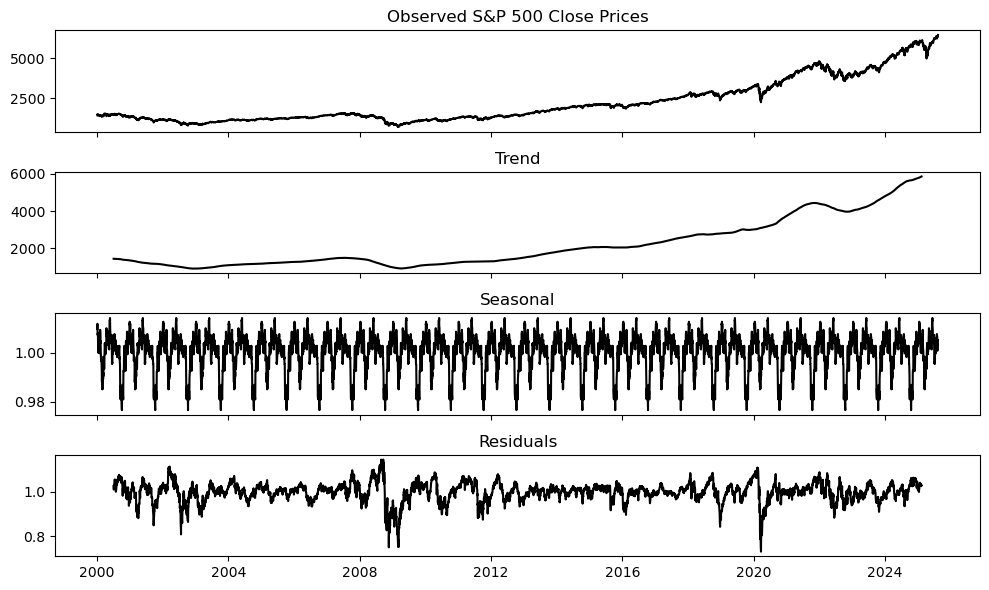

In [30]:
#Seasonal and trendancy overview
result = seasonal_decompose(closing_prices, model='multiplicative', period=252)  # 252 ≈ Round trading days in a year

plt.rcParams.update({'figure.figsize': (10, 6)})

fig, axs = plt.subplots(4, 1, sharex=True)

axs[0].plot(result.observed, color='black')
axs[0].set_title('Observed S&P 500 Close Prices')

axs[1].plot(result.trend, color='black')
axs[1].set_title('Trend')

axs[2].plot(result.seasonal, color='black')
axs[2].set_title('Seasonal')

axs[3].plot(result.resid, color='black')
axs[3].set_title('Residuals')

plt.tight_layout()
plt.show()

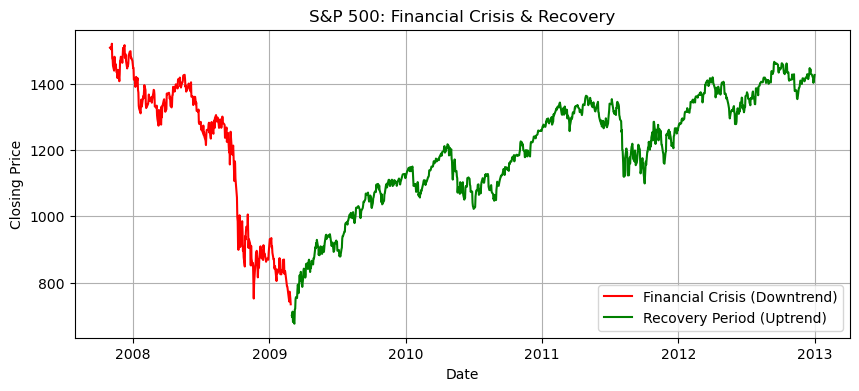

In [31]:
#2008 financial crisis
crisis_start, crisis_end = '2007-11-01', '2009-03-01'
recovery_start, recovery_end = '2009-03-02', '2012-12-31'

crisis_data = closing_prices.loc[crisis_start:crisis_end]
recovery_data = closing_prices.loc[recovery_start:recovery_end]

plt.figure(figsize=(10,4))
plt.plot(crisis_data.index, crisis_data.values, color='red', label='Financial Crisis (Downtrend)')
plt.plot(recovery_data.index, recovery_data.values, color='green', label='Recovery Period (Uptrend)')
plt.title('S&P 500: Financial Crisis & Recovery')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()

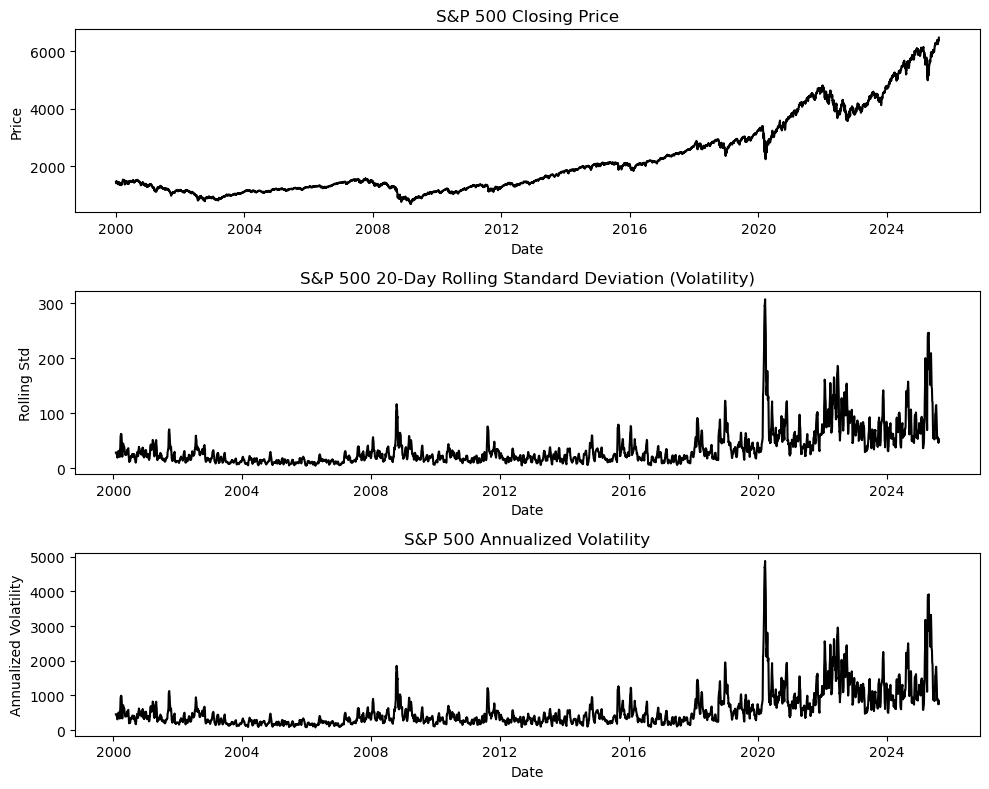

In [33]:
#Volatility Analysis
# Calculating 20-Day Rolling Standard Deviation
rolling_std_20 = closing_prices.rolling(window=20).std()

# Annual volatility by round 252 trading days
annualized_volatility = rolling_std_20 * (252**0.5)

plt.figure(figsize=(10,8))

# Closing Price
plt.subplot(3,1,1)
plt.plot(closing_prices.index, closing_prices.values, color='black')
plt.title('S&P 500 Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')

# 20-Day Rolling Standard Deviation
plt.subplot(3,1,2)
plt.plot(rolling_std_20.index, rolling_std_20.values, color='black')
plt.title('S&P 500 20-Day Rolling Standard Deviation (Volatility)')
plt.xlabel('Date')
plt.ylabel('Rolling Std')

# Annual volatility
plt.subplot(3,1,3)
plt.plot(annualized_volatility.index, annualized_volatility.values, color='black')
plt.title('S&P 500 Annualized Volatility')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')

plt.tight_layout()
plt.show()

Detected 21 price outliers and 52 volume outliers.


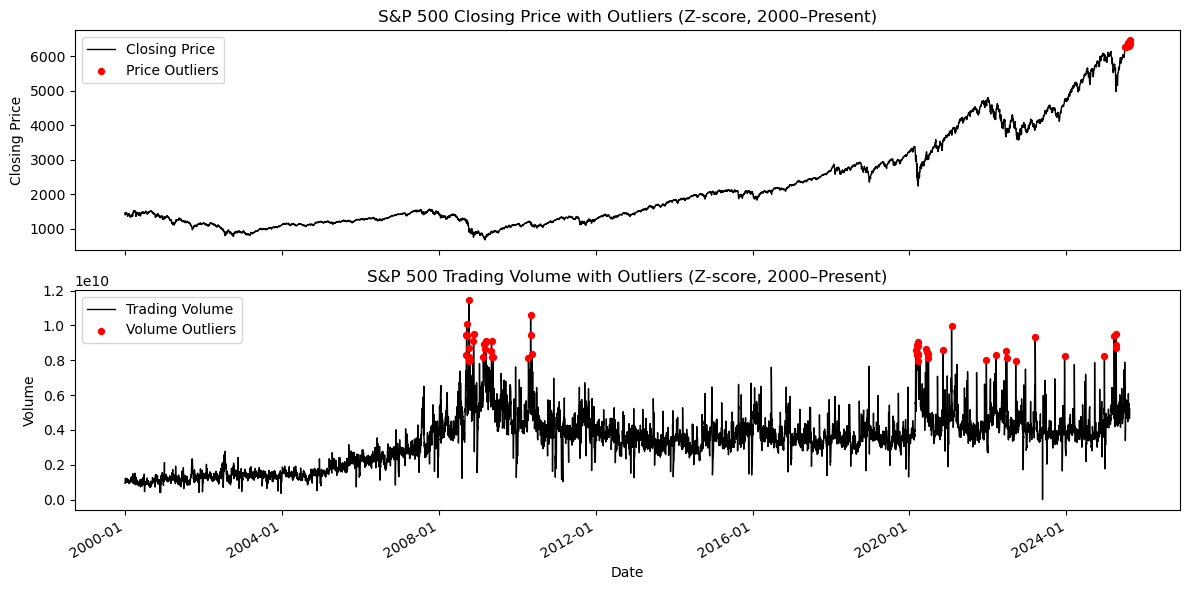

In [55]:
# Parameters
csv_path   = "sp500_daily_all_clean.csv" 
z_threshold = 3.0                         

# Loading file
df = pd.read_csv(csv_path)
# 找列名
cols_lower = {c.lower(): c for c in df.columns}
date_col   = cols_lower.get("date")
close_col  = cols_lower.get("close")
vol_col    = cols_lower.get("volume")
assert date_col and close_col and vol_col, "列名需包含 Date / Close / Volume"

df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df = df.dropna(subset=[date_col]).sort_values(date_col).set_index(date_col)
df[close_col] = pd.to_numeric(df[close_col], errors="coerce")
df[vol_col]   = pd.to_numeric(df[vol_col],   errors="coerce")
data = df.loc["2000-01-01":, [close_col, vol_col]].dropna()

# Z-score and Outliers
def z_score(s: pd.Series):
    return (s - s.mean()) / s.std()

data["close_z"] = z_score(data[close_col])
data["vol_z"]   = z_score(data[vol_col])

price_outliers  = data[data["close_z"].abs() > z_threshold]
volume_outliers = data[data["vol_z"].abs()   > z_threshold]

print(f"Detected {len(price_outliers)} price outliers and {len(volume_outliers)} volume outliers.")

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axes[0].plot(data.index, data[close_col], color="black", label="Closing Price", linewidth=1)
axes[0].scatter(price_outliers.index, price_outliers[close_col],
                color="red", s=18, label="Price Outliers", zorder=5)
axes[0].set_title("S&P 500 Closing Price with Outliers (Z-score, 2000–Present)")
axes[0].set_ylabel("Closing Price")
axes[0].legend()

axes[1].plot(data.index, data[vol_col], color="black", label="Trading Volume", linewidth=1)
axes[1].scatter(volume_outliers.index, volume_outliers[vol_col],
                color="red", s=18, label="Volume Outliers", zorder=5)
axes[1].set_title("S&P 500 Trading Volume with Outliers (Z-score, 2000–Present)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Volume")
axes[1].legend()

for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

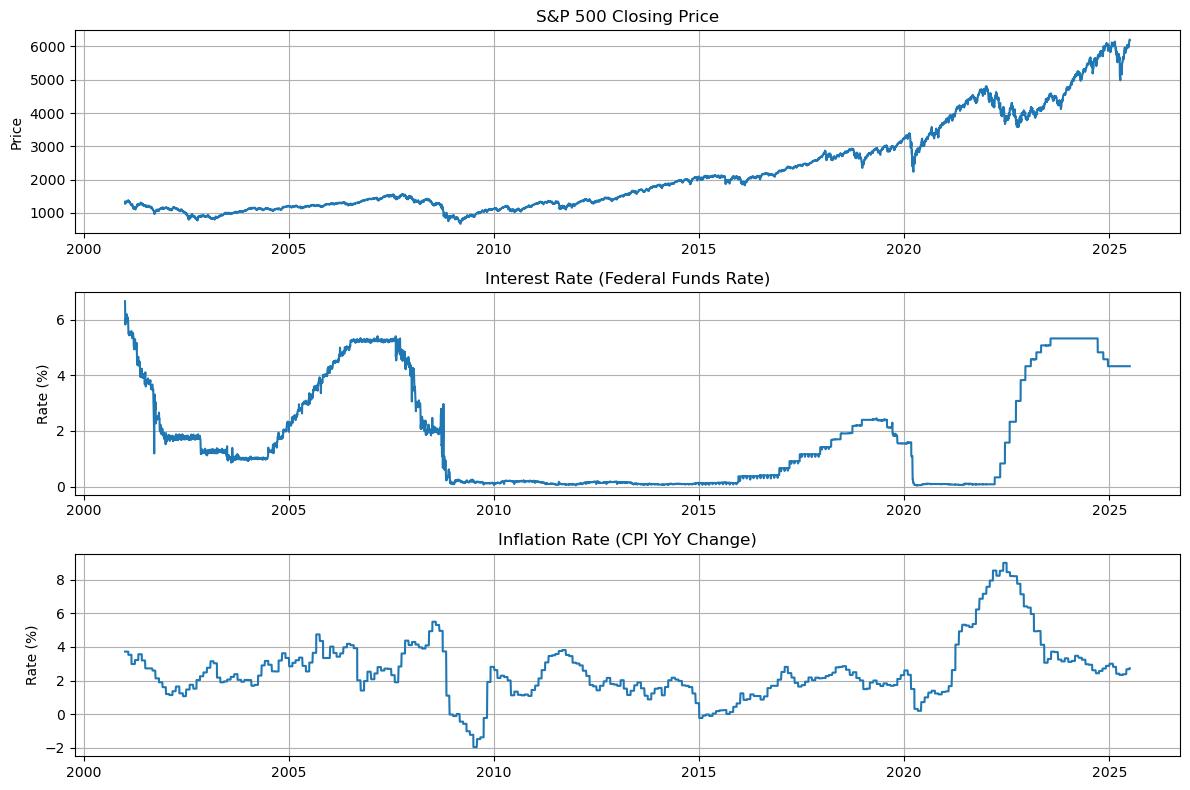

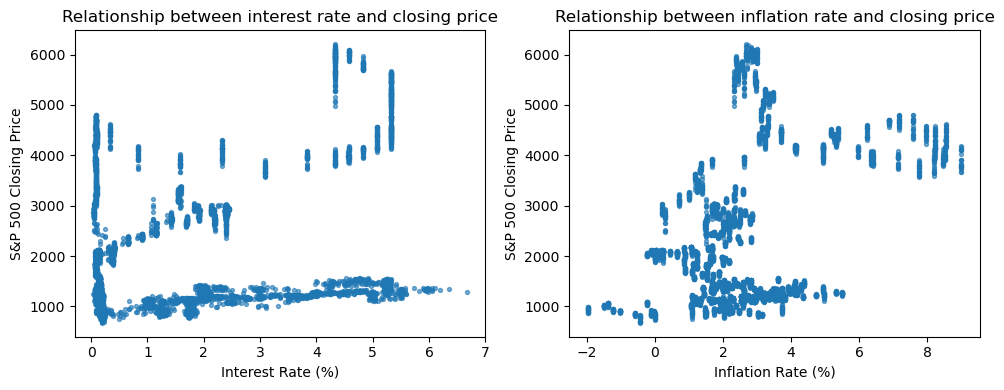

In [75]:

START = dt.datetime(2000, 1, 1)
END   = dt.datetime(2025, 8, 1) 

sp500 = pd.read_csv("sp500_daily_all_clean.csv", parse_dates=["Date"]).sort_values("Date")
sp500 = sp500[(sp500["Date"] >= START) & (sp500["Date"] <= END)].copy()
sp500 = sp500.set_index("Date")[["Close"]]

ir = web.DataReader("DFF", "fred", START, END)               # Interest rate, daily
cpi = web.DataReader("CPIAUCSL", "fred", START, END)         # CPI, monthly

cpi["Inflation_Rate"] = cpi["CPIAUCSL"].pct_change(12) * 100 
infl_m = cpi[["Inflation_Rate"]].copy()

infl_d = (infl_m
          .resample("D")
          .ffill()
          .loc[START:END])

ir.columns = ["Interest_Rate"]
ir_d = (ir
        .resample("D")
        .ffill()
        .loc[START:END])

macro = sp500.join(ir_d, how="inner").join(infl_d, how="inner")
macro = macro.dropna()

fig = plt.figure(figsize=(12, 8))

ax1 = plt.subplot(3, 1, 1)
ax1.plot(macro.index, macro["Close"])
ax1.set_title("S&P 500 Closing Price")
ax1.set_ylabel("Price")
ax1.grid(True)

ax2 = plt.subplot(3, 1, 2, sharex=ax1)
ax2.plot(macro.index, macro["Interest_Rate"])
ax2.set_title("Interest Rate (Federal Funds Rate)")
ax2.set_ylabel("Rate (%)")
ax2.grid(True)

ax3 = plt.subplot(3, 1, 3, sharex=ax1)
ax3.plot(macro.index, macro["Inflation_Rate"])
ax3.set_title("Inflation Rate (CPI YoY Change)")
ax3.set_ylabel("Rate (%)")
ax3.grid(True)

for ax in (ax1, ax2, ax3):
    ax.xaxis.set_major_locator(mdates.YearLocator(5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(10, 4))

ax4 = plt.subplot(1, 2, 1)
ax4.scatter(macro["Interest_Rate"], macro["Close"], s=8, alpha=0.6)
ax4.set_title("Relationship between interest rate and closing price")
ax4.set_xlabel("Interest Rate (%)")
ax4.set_ylabel("S&P 500 Closing Price")

ax5 = plt.subplot(1, 2, 2)
ax5.scatter(macro["Inflation_Rate"], macro["Close"], s=8, alpha=0.6)
ax5.set_title("Relationship between inflation rate and closing price")
ax5.set_xlabel("Inflation Rate (%)")
ax5.set_ylabel("S&P 500 Closing Price")

plt.tight_layout()
plt.show()

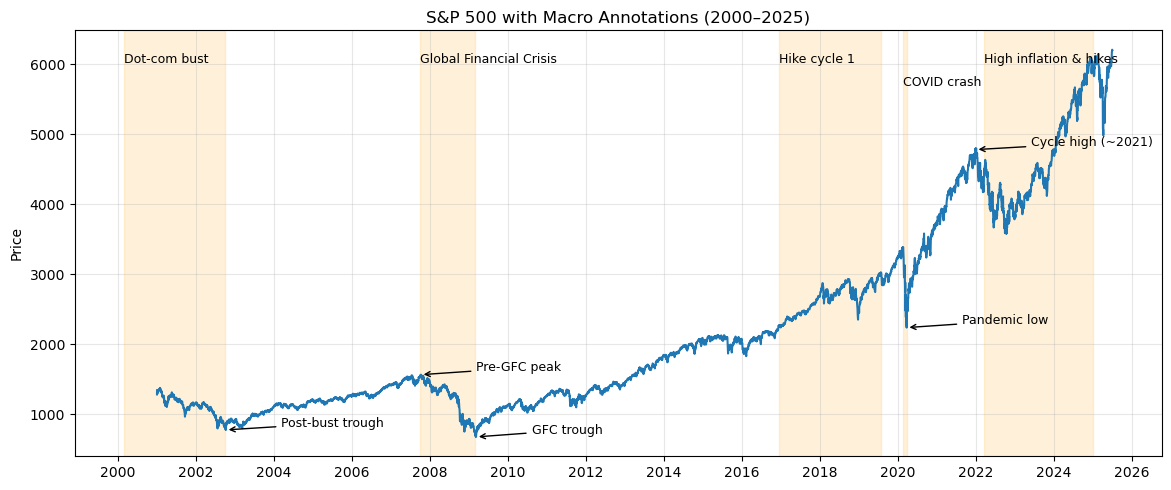

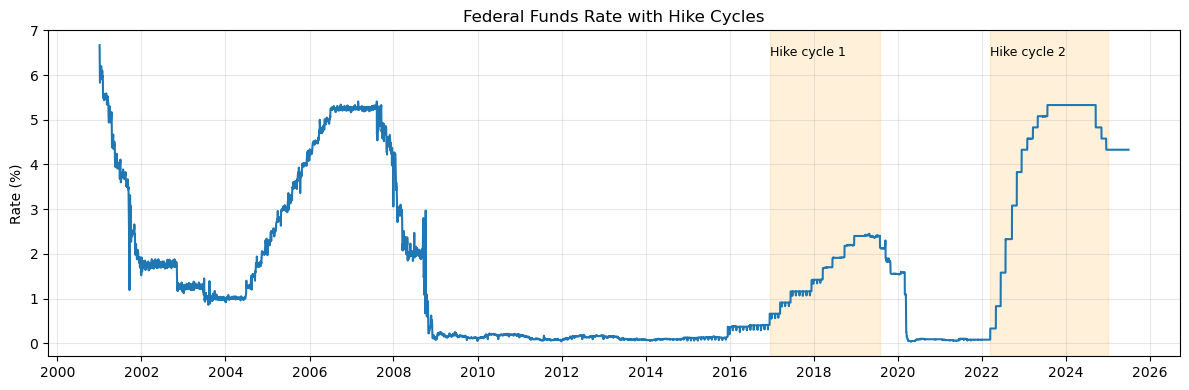

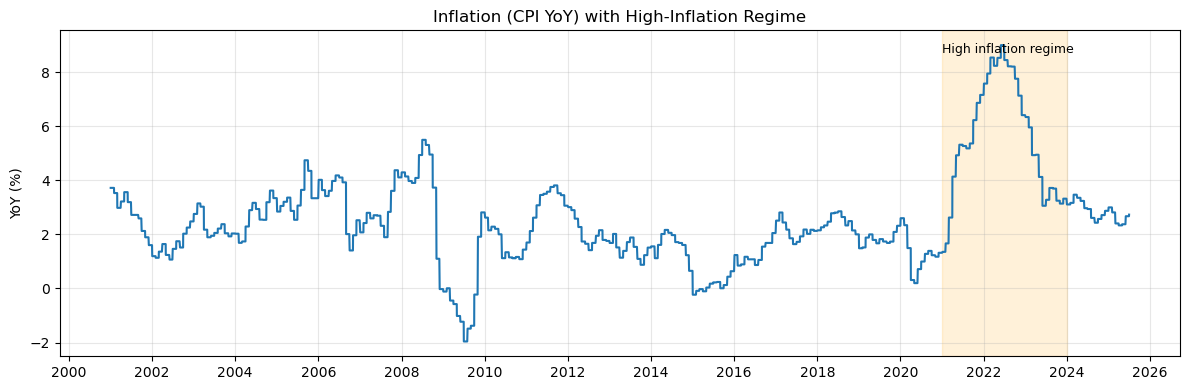

In [76]:
START = dt.datetime(2000, 1, 1)
END   = dt.datetime(2025, 8, 1)

sp500 = pd.read_csv("sp500_daily_all_clean.csv", parse_dates=["Date"]).sort_values("Date")
sp500 = sp500[(sp500["Date"] >= START) & (sp500["Date"] <= END)].copy()
sp500 = sp500.set_index("Date")[["Close"]]

ir = web.DataReader("DFF", "fred", START, END)               # Fed Funds Rate
cpi = web.DataReader("CPIAUCSL", "fred", START, END)         # CPI (monthly)

cpi["Inflation_Rate"] = cpi["CPIAUCSL"].pct_change(12) * 100
infl_d = cpi[["Inflation_Rate"]].resample("D").ffill()

ir_d = ir.rename(columns={"DFF": "Interest_Rate"}).resample("D").ffill()
macro = sp500.join(ir_d, how="inner").join(infl_d, how="inner").dropna()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(macro.index, macro["Close"], linewidth=1.5)
ax.set_title("S&P 500 with Macro Annotations (2000–2025)")
ax.set_ylabel("Price")
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

def shade(start, end, label, y=0.95):
    ax.axvspan(pd.Timestamp(start), pd.Timestamp(end), alpha=0.15, color="orange")
    ax.text(pd.Timestamp(start), ax.get_ylim()[1]*y, label, va="top", fontsize=9)

shade("2000-03-01", "2002-10-01", "Dot-com bust")
shade("2007-10-01", "2009-03-01", "Global Financial Crisis")
shade("2020-02-15", "2020-03-31", "COVID crash", y=0.9)
shade("2016-12-14", "2019-07-31", "Hike cycle 1")
shade("2022-03-16", "2024-12-31", "High inflation & hikes")

def annotate(date_str, text, xytext=(40, 0.15)):
    d = pd.Timestamp(date_str)
    if d in macro.index:
        ax.annotate(text,
                    xy=(d, macro.loc[d, "Close"]),
                    xytext=xytext,
                    textcoords="offset points",
                    arrowprops=dict(arrowstyle="->", lw=1),
                    ha="left", va="bottom", fontsize=9)

annotate("2002-10-09", "Post-bust trough")
annotate("2007-10-09", "Pre-GFC peak")
annotate("2009-03-09", "GFC trough")
annotate("2020-03-23", "Pandemic low")
annotate("2021-12-30", "Cycle high (~2021)")

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(macro.index, macro["Interest_Rate"], linewidth=1.5)
ax.set_title("Federal Funds Rate with Hike Cycles")
ax.set_ylabel("Rate (%)")
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

ax.axvspan(pd.Timestamp("2016-12-14"), pd.Timestamp("2019-07-31"), alpha=0.15, color="orange")
ax.text(pd.Timestamp("2016-12-14"), ax.get_ylim()[1]*0.95, "Hike cycle 1", va="top", fontsize=9)
ax.axvspan(pd.Timestamp("2022-03-16"), pd.Timestamp("2024-12-31"), alpha=0.15, color="orange")
ax.text(pd.Timestamp("2022-03-16"), ax.get_ylim()[1]*0.95, "Hike cycle 2", va="top", fontsize=9)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(macro.index, macro["Inflation_Rate"], linewidth=1.5)
ax.set_title("Inflation (CPI YoY) with High-Inflation Regime")
ax.set_ylabel("YoY (%)")
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

ax.axvspan(pd.Timestamp("2021-01-01"), pd.Timestamp("2023-12-31"), alpha=0.15, color="orange")
ax.text(pd.Timestamp("2021-01-01"), ax.get_ylim()[1]*0.95, "High inflation regime", va="top", fontsize=9)

plt.tight_layout()
plt.show()

In [83]:
sp500_recent = sp500.loc[sp500.index >= "2020-01-01"].copy()

# Calculate the gap in days between consecutive records
gap_recent = sp500_recent.index.to_series().diff().dt.days.fillna(0).astype(int)
gap_counts_recent = gap_recent.value_counts().sort_index()

print("\nTime interval distribution (days) since 2020-01-01:\n", gap_counts_recent.head(10))

# Identify abnormal gaps (>3 days)
abnormal_recent = sp500_recent[gap_recent > 3]
print(f"\nAbnormal intervals (>3 days) since 2020-01-01, total {len(abnormal_recent)} cases:")
display(abnormal_recent.head(10))

# Build an approximate trading-day calendar (remove weekends) and find missing days
all_days_recent = pd.date_range(sp500_recent.index.min(), sp500_recent.index.max(), freq="D")
biz_like_recent = all_days_recent[~all_days_recent.weekday.isin([5, 6])]  # remove Saturdays and Sundays
merged_recent = pd.DataFrame(index=biz_like_recent).join(sp500_recent[["Close"]], how="left")
missing_recent = merged_recent[merged_recent["Close"].isna()].index

print(f"\nApprox. trading-day gaps (after removing weekends): {len(missing_recent)}")
print("Example missing days:", list(missing_recent[:10]))

# Weekly and monthly seasonality (based on mean close price)
weekly_recent = sp500_recent["Close"].groupby(sp500_recent.index.weekday).agg(["mean","std"])
monthly_recent = sp500_recent["Close"].groupby(sp500_recent.index.month).agg(["mean","std"])



Time interval distribution (days) since 2020-01-01:
 Date
0       1
1    1105
2      12
3     251
4      42
Name: count, dtype: int64

Abnormal intervals (>3 days) since 2020-01-01, total 42 cases:


,Close,Volume
Date,,
2020-01-21,3320.790039,4104840000
2020-02-18,3370.290039,3750400000
2020-04-13,2761.629883,5319530000
2020-05-26,2991.770020,5848500000
2020-07-06,3179.719971,4759160000
2020-09-08,3331.840088,4694330000
2020-12-28,3735.360107,3535460000
2021-01-04,3700.649902,5015000000
2021-01-19,3798.909912,5014440000



Approx. trading-day gaps (after removing weekends): 54
Example missing days: [Timestamp('2020-01-20 00:00:00'), Timestamp('2020-02-17 00:00:00'), Timestamp('2020-04-10 00:00:00'), Timestamp('2020-05-25 00:00:00'), Timestamp('2020-07-03 00:00:00'), Timestamp('2020-09-07 00:00:00'), Timestamp('2020-11-26 00:00:00'), Timestamp('2020-12-25 00:00:00'), Timestamp('2021-01-01 00:00:00'), Timestamp('2021-01-18 00:00:00')]


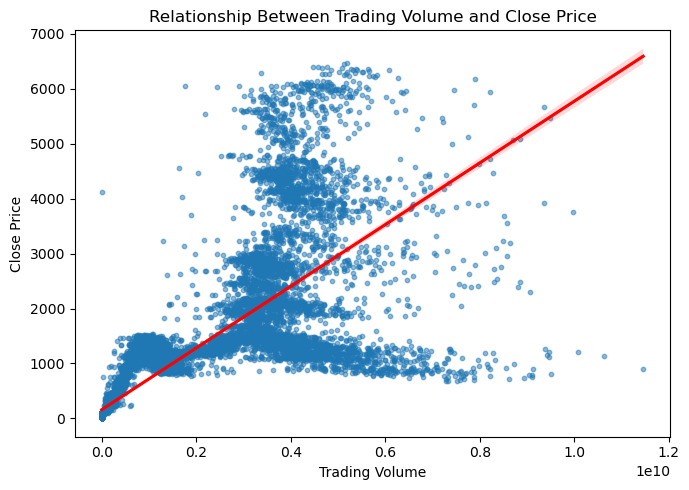

Pearson Correlation Coefficient: 0.8023
P-value: 0.0000
There is a statistically significant positive correlation between trading volume and close price.


In [87]:
# 1) Load data
sp500 = pd.read_csv("sp500_daily_all_clean.csv", parse_dates=["Date"]).sort_values("Date")
sp500 = sp500.set_index("Date")

# 2) Drop missing values in Close & Volume
df = sp500.dropna(subset=["Close", "Volume"]).copy()

# 3) Pearson correlation & p-value
r, p = stats.pearsonr(df["Volume"], df["Close"])

# 4) Scatter plot + regression line
plt.figure(figsize=(7,5))
sns.regplot(x="Volume", y="Close", data=df, scatter_kws={"s":10, "alpha":0.5}, line_kws={"color":"red"})
plt.title("Relationship Between Trading Volume and Close Price")
plt.xlabel("Trading Volume")
plt.ylabel("Close Price")
plt.tight_layout()
plt.show()

# 5) Print correlation results
print(f"Pearson Correlation Coefficient: {r:.4f}")
print(f"P-value: {p:.4f}")
if p < 0.05:
    print("There is a statistically significant positive correlation between trading volume and close price.")
else:
    print("No statistically significant correlation between trading volume and close price.")

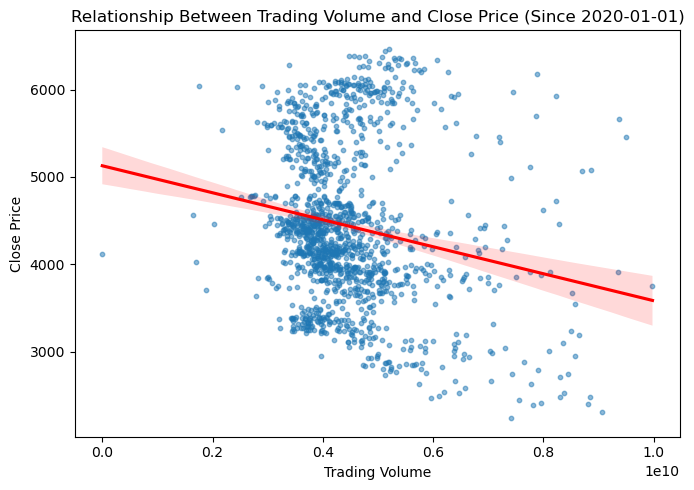

Pearson Correlation Coefficient (since 2020): -0.1843
P-value (since 2020): 0.0000
There is a statistically significant positive correlation between trading volume and close price (since 2020).


In [88]:
# Filter for dates since 2020-01-01
df_recent = sp500.loc[sp500.index >= "2020-01-01"].dropna(subset=["Close", "Volume"]).copy()

# Pearson correlation & p-value
r_recent, p_recent = stats.pearsonr(df_recent["Volume"], df_recent["Close"])

# Scatter plot + regression line (with CI shading)
plt.figure(figsize=(7,5))
sns.regplot(x="Volume", y="Close", data=df_recent,
            scatter_kws={"s":10, "alpha":0.5},
            line_kws={"color":"red"})
plt.title("Relationship Between Trading Volume and Close Price (Since 2020-01-01)")
plt.xlabel("Trading Volume")
plt.ylabel("Close Price")
plt.tight_layout()
plt.show()

# Print correlation results
print(f"Pearson Correlation Coefficient (since 2020): {r_recent:.4f}")
print(f"P-value (since 2020): {p_recent:.4f}")
if p_recent < 0.05:
    print("There is a statistically significant positive correlation between trading volume and close price (since 2020).")
else:
    print("No statistically significant correlation between trading volume and close price (since 2020).")

Feature Correction

In [91]:
df = pd.read_csv("sp500_daily_all_clean.csv", parse_dates=["Date"]).sort_values("Date")
df = df.set_index("Date")[["Open","High","Low","Close","Volume"]].copy()

print(df.head(3))
print(df.columns.tolist())

                 Open       High        Low      Close  Volume
Date                                                          
1927-12-30  17.660000  17.660000  17.660000  17.660000       0
1928-01-03  17.760000  17.760000  17.760000  17.760000       0
1928-01-04  17.719999  17.719999  17.719999  17.719999       0
['Open', 'High', 'Low', 'Close', 'Volume']


In [92]:
# keep data since 2000-01-01 (or change the date)
df = df.loc[df.index >= "2000-01-01"].copy()

# Drop exact duplicates (if any)
df = df[~df.index.duplicated(keep="last")].copy()

# Basic NA report
na_report = df.isna().sum().sort_values(ascending=False)
print("NA counts:\n", na_report.head(10))

NA counts:
 Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


Total points: 6442  |  Outliers (IQR): 110  |  lower=-638,222,500, upper=7,148,537,500


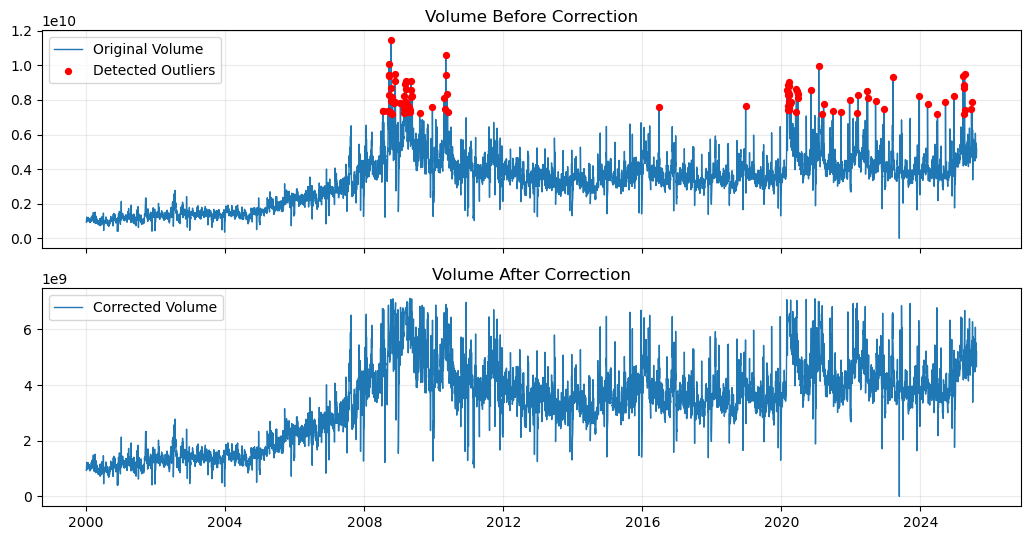

In [98]:

Q1 = df["Volume"].quantile(0.25)
Q3 = df["Volume"].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df["Volume_outlier"] = ((df["Volume"] < lower) | (df["Volume"] > upper))

df["Volume_corrected"] = df["Volume"].where(~df["Volume_outlier"])
df["Volume_corrected"] = df["Volume_corrected"].interpolate(method="time").bfill().ffill()

total_n = len(df)
n_out = int(df["Volume_outlier"].sum())
print(f"Total points: {total_n}  |  Outliers (IQR): {n_out}  "
      f"|  lower={lower:,.0f}, upper={upper:,.0f}")

os.makedirs("figures", exist_ok=True)
fig, axes = plt.subplots(2, 1, figsize=(10.5, 5.5), sharex=True)

axes[0].plot(df.index, df["Volume"], color="tab:blue", linewidth=1.0, label="Original Volume")
out_idx = df.index[df["Volume_outlier"]]
axes[0].scatter(out_idx, df.loc[out_idx, "Volume"], s=18, color="red", label="Detected Outliers", zorder=3)
axes[0].set_title("Volume Before Correction")
axes[0].legend(loc="upper left")
axes[0].grid(alpha=0.25)

axes[1].plot(df.index, df["Volume_corrected"], color="tab:blue", linewidth=1.0, label="Corrected Volume")
axes[1].set_title("Volume After Correction")
axes[1].legend(loc="upper left")
axes[1].grid(alpha=0.25)

plt.tight_layout()
plt.show()

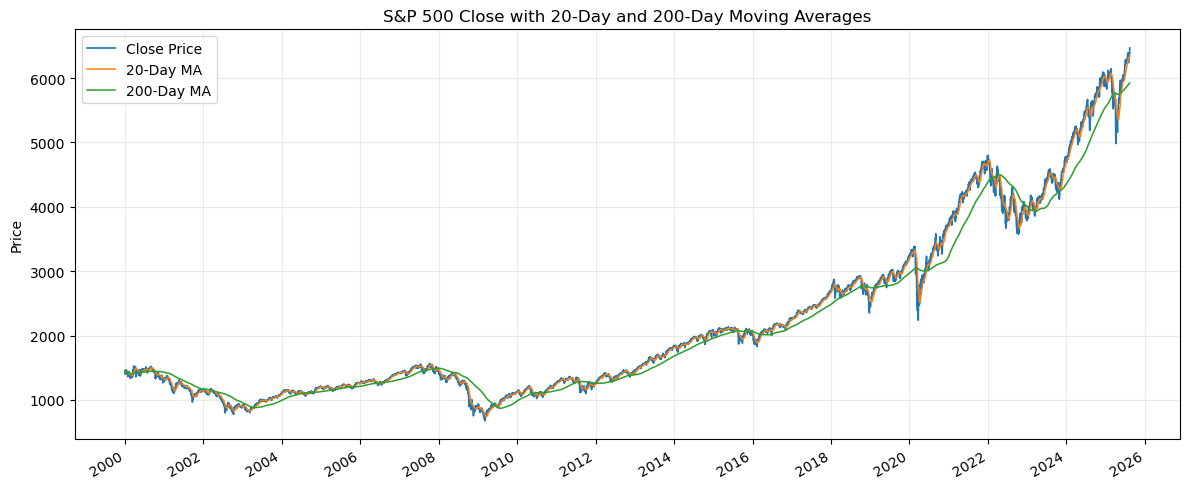

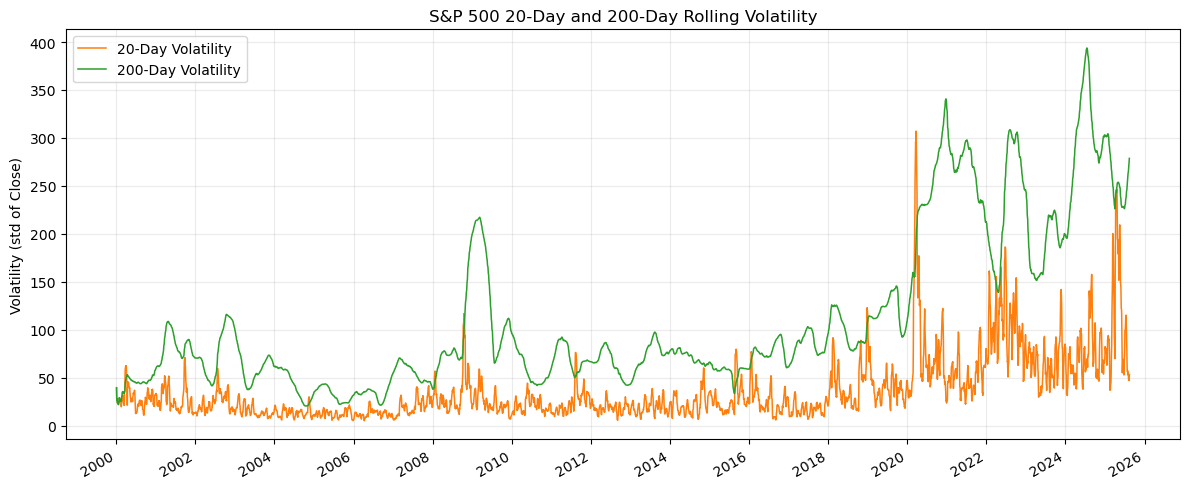

In [109]:
df = pd.read_csv("sp500_daily_all_clean.csv", parse_dates=["Date"]).sort_values("Date")

if "Date" in df.columns:
    df = df.set_index("Date")
df = df[["Open","High","Low","Close","Volume"]].copy()

df = df.loc[df.index >= "2000-01-01"].copy()

short_window = 20   # short-term window (days)
long_window  = 200  # long-term window (days)

df[f"MA_{short_window}"] = df["Close"].rolling(short_window, min_periods=1).mean()
df[f"MA_{long_window}"]  = df["Close"].rolling(long_window,  min_periods=1).mean()

df["Trend_Spread"] = df[f"MA_{short_window}"] - df[f"MA_{long_window}"]


df[f"Vol_{short_window}"] = df["Close"].rolling(short_window, min_periods=2).std()
df[f"Vol_{long_window}"]  = df["Close"].rolling(long_window,  min_periods=2).std()


fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df.index, df["Close"], label="Close Price", color="tab:blue", linewidth=1.2)
ax.plot(df.index, df[f"MA_{short_window}"], label=f"{short_window}-Day MA", color="tab:orange", linewidth=1.1)
ax.plot(df.index, df[f"MA_{long_window}"],  label=f"{long_window}-Day MA",  color="tab:green",  linewidth=1.1)

ax.set_title(f"S&P 500 Close with {short_window}-Day and {long_window}-Day Moving Averages")
ax.set_ylabel("Price")
ax.legend(loc="upper left")
ax.grid(alpha=0.25)

ax.xaxis.set_major_locator(mdates.YearLocator(2))            # tick every 2 years
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df.index, df[f"Vol_{short_window}"], label=f"{short_window}-Day Volatility", color="tab:orange", linewidth=1.1)
ax.plot(df.index, df[f"Vol_{long_window}"],  label=f"{long_window}-Day Volatility",  color="tab:green",  linewidth=1.1)

ax.set_title(f"S&P 500 {short_window}-Day and {long_window}-Day Rolling Volatility")
ax.set_ylabel("Volatility (std of Close)")
ax.legend(loc="upper left")
ax.grid(alpha=0.25)

ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


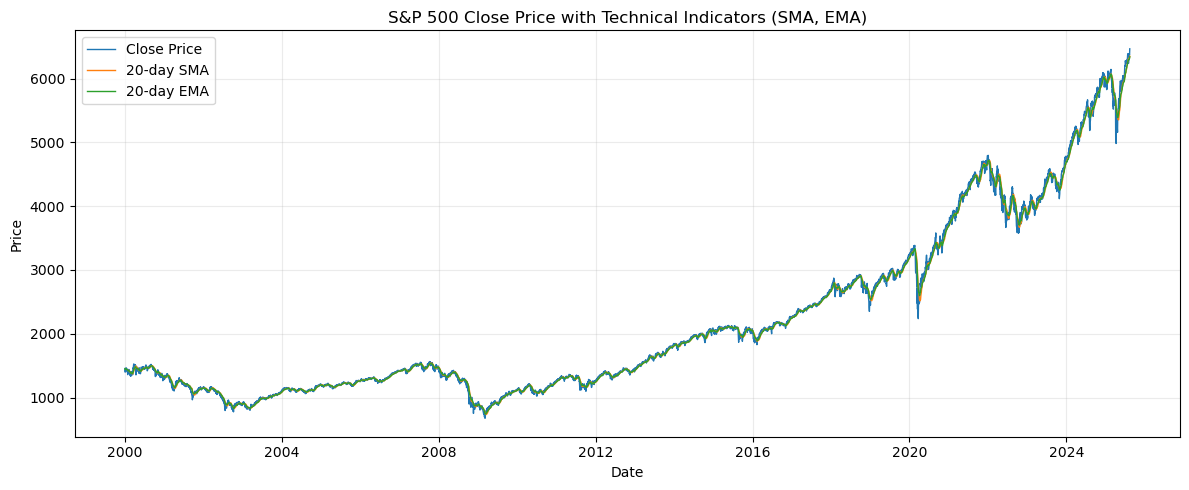

In [111]:
df = pd.read_csv("sp500_daily_all_clean.csv", parse_dates=["Date"]).sort_values("Date")
df = df.set_index("Date")[["Open","High","Low","Close","Volume"]].copy()
df = df.loc[df.index >= "2000-01-01"].copy()

# Smoothing: SMA & EMA 20

df["SMA_20"] = df["Close"].rolling(20).mean()
df["EMA_20"] = df["Close"].ewm(span=20, adjust=False).mean()

plt.figure(figsize=(12,5))
plt.plot(df.index, df["Close"], label="Close Price", linewidth=1)
plt.plot(df.index, df["SMA_20"], label="20-day SMA", linewidth=1)
plt.plot(df.index, df["EMA_20"], label="20-day EMA", linewidth=1)
plt.title("S&P 500 Close Price with Technical Indicators (SMA, EMA)")
plt.xlabel("Date"); plt.ylabel("Price"); plt.legend(); plt.grid(alpha=0.25)
plt.tight_layout(); plt.show()


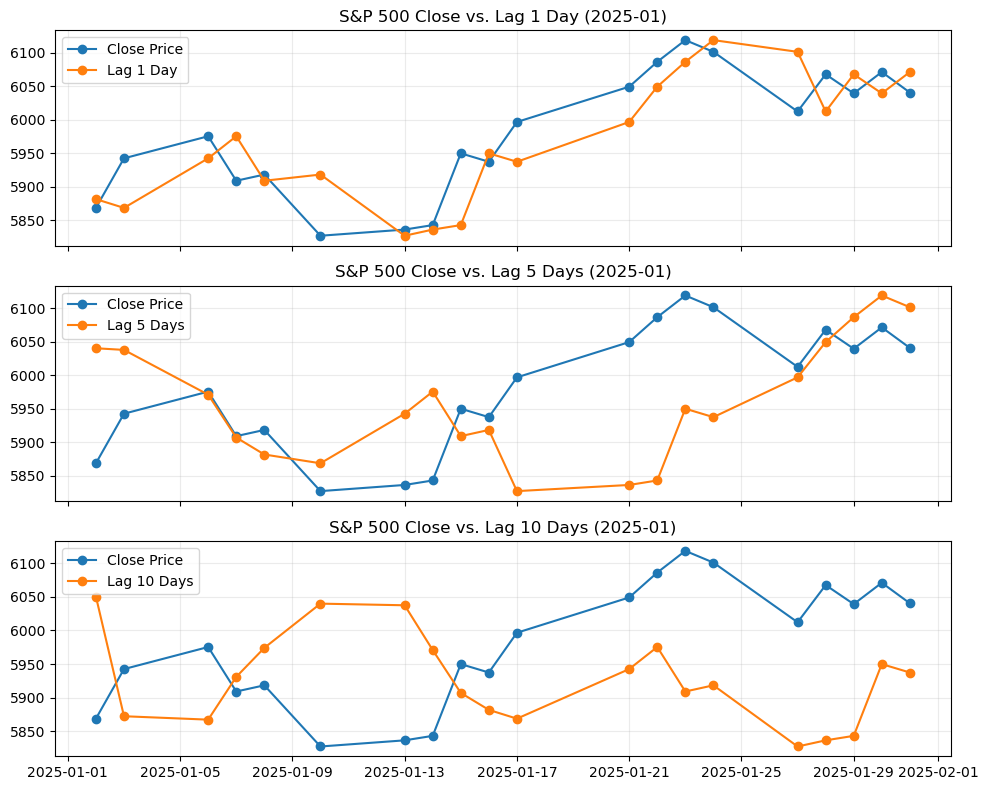

In [114]:
# Lag features & mini-plots

# Lags
df["Lag_1"]  = df["Close"].shift(1)
df["Lag_5"]  = df["Close"].shift(5)
df["Lag_10"] = df["Close"].shift(10)

sample = df.loc["2025-01"].copy()

fig, axes = plt.subplots(3, 1, figsize=(10,8), sharex=True)
axes[0].plot(sample.index, sample["Close"], marker="o", label="Close Price")
axes[0].plot(sample.index, sample["Lag_1"],  marker="o", label="Lag 1 Day")
axes[0].set_title("S&P 500 Close vs. Lag 1 Day (2025-01)"); axes[0].legend(); axes[0].grid(alpha=0.25)

axes[1].plot(sample.index, sample["Close"], marker="o", label="Close Price")
axes[1].plot(sample.index, sample["Lag_5"],  marker="o", label="Lag 5 Days")
axes[1].set_title("S&P 500 Close vs. Lag 5 Days (2025-01)"); axes[1].legend(); axes[1].grid(alpha=0.25)

axes[2].plot(sample.index, sample["Close"], marker="o", label="Close Price")
axes[2].plot(sample.index, sample["Lag_10"], marker="o", label="Lag 10 Days")
axes[2].set_title("S&P 500 Close vs. Lag 10 Days (2025-01)"); axes[2].legend(); axes[2].grid(alpha=0.25)

plt.tight_layout(); plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_26760\2328110297.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sp500_data['Inflation_Rate'] = sp500_data['Inflation_Rate'].fillna(method='ffill')


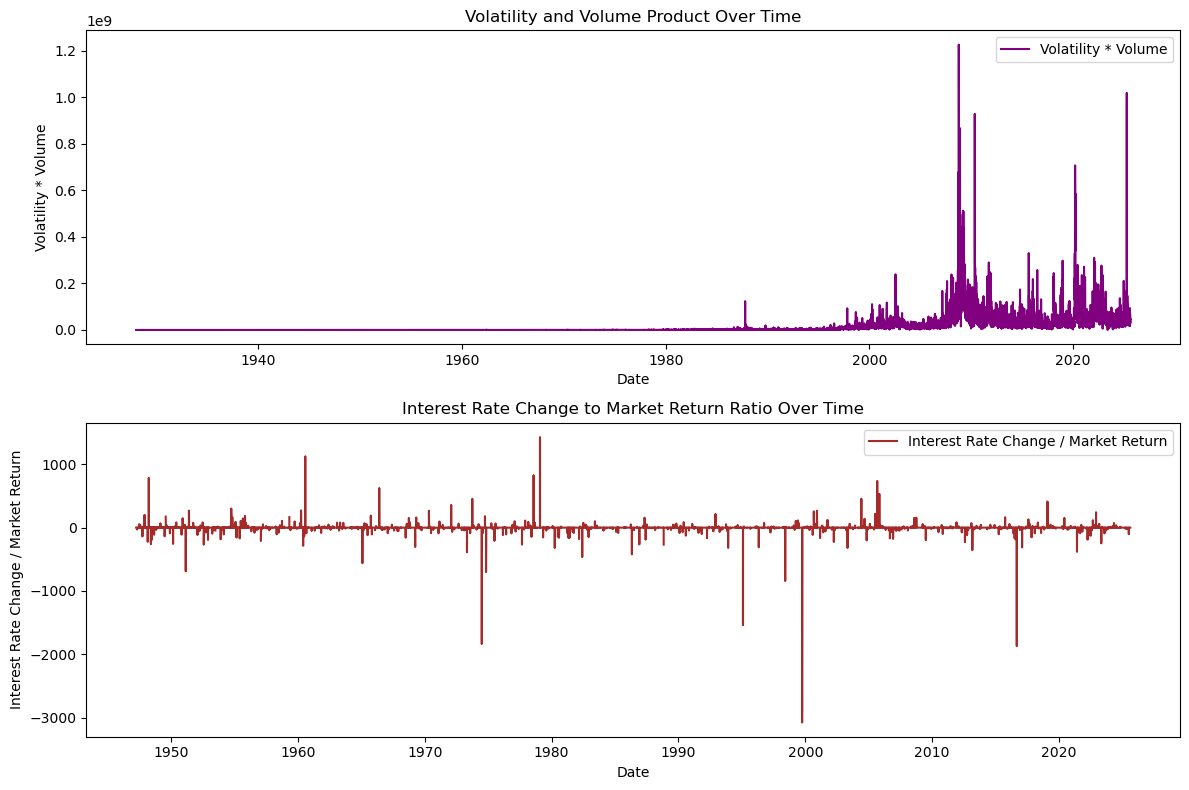

In [119]:
sp500_data = pd.read_csv("sp500_daily_all_clean.csv", parse_dates=['Date'])
sp500_data = sp500_data.sort_values('Date').set_index('Date')

sp500_data['Volatility'] = (sp500_data['High'] - sp500_data['Low']) / sp500_data['Open']

sp500_data['Log_Return'] = np.log(sp500_data['Close'] / sp500_data['Close'].shift(1))

start_date = sp500_data.index.min()
end_date = sp500_data.index.max()

cpi_data = web.DataReader('CPIAUCSL', 'fred', start_date, end_date)
cpi_data['Inflation_Rate'] = cpi_data['CPIAUCSL'].pct_change() * 100

sp500_data = sp500_data.merge(cpi_data[['Inflation_Rate']], left_index=True, right_index=True, how='left')
sp500_data['Inflation_Rate'] = sp500_data['Inflation_Rate'].fillna(method='ffill')

sp500_data['Volatility_Volume_Product'] = sp500_data['Volatility'] * sp500_data['Volume']

sp500_data['Interest_Rate_Change'] = sp500_data['Inflation_Rate'].diff()

sp500_data['Interest_Rate_to_Return'] = sp500_data['Interest_Rate_Change'] / sp500_data['Log_Return']

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(sp500_data.index, sp500_data['Volatility_Volume_Product'], label='Volatility * Volume', color='purple')
plt.title('Volatility and Volume Product Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility * Volume')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(sp500_data.index, sp500_data['Interest_Rate_to_Return'], label='Interest Rate Change / Market Return', color='brown')
plt.title('Interest Rate Change to Market Return Ratio Over Time')
plt.xlabel('Date')
plt.ylabel('Interest Rate Change / Market Return')
plt.legend()

plt.tight_layout()
plt.show()

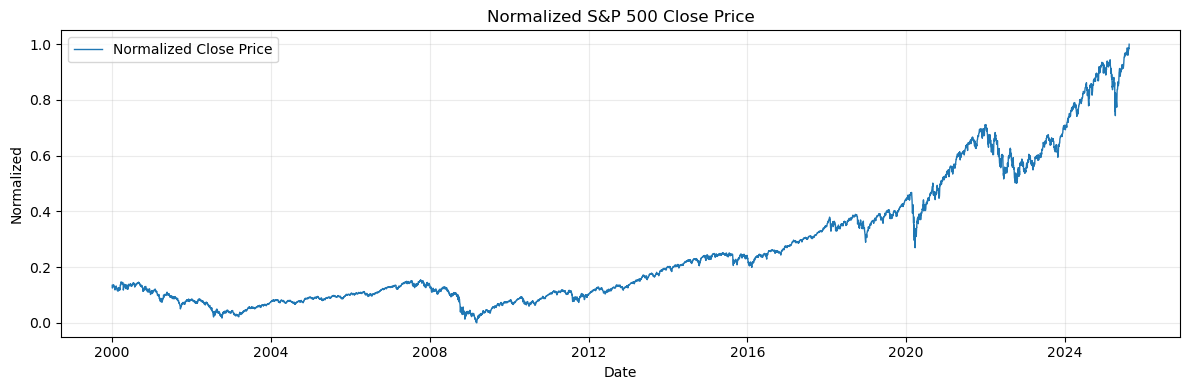

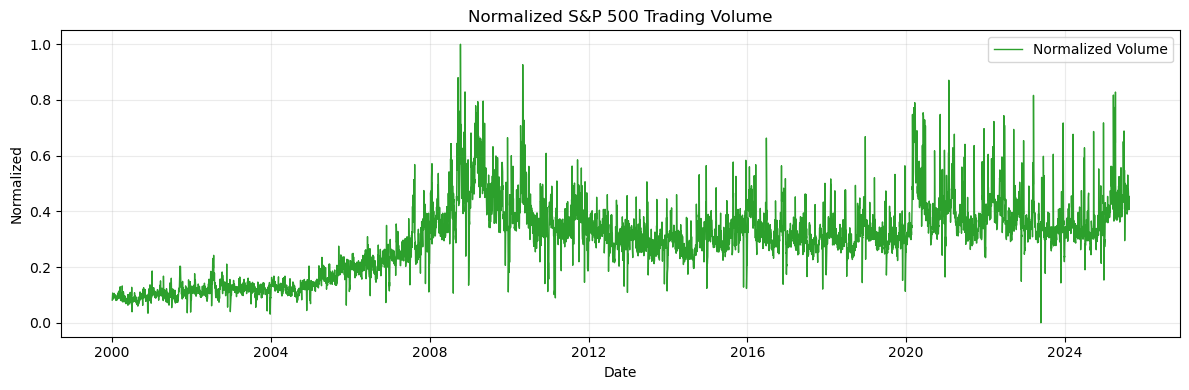

In [116]:
# Normalization (MinMax)
features_to_normalize = ["Close","Volume"]
df_norm = df.copy()

scaler = MinMaxScaler()
df_norm[features_to_normalize] = scaler.fit_transform(df_norm[features_to_normalize])

# Plot normalized Close
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df_norm.index, df_norm["Close"], label="Normalized Close Price", linewidth=1.0)
ax.set_title("Normalized S&P 500 Close Price")
ax.set_xlabel("Date"); ax.set_ylabel("Normalized"); ax.legend(); ax.grid(alpha=0.25)
plt.tight_layout(); plt.show()

# Plot normalized Volume
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(df_norm.index, df_norm["Volume"], color="tab:green", label="Normalized Volume", linewidth=1.0)
ax.set_title("Normalized S&P 500 Trading Volume")
ax.set_xlabel("Date"); ax.set_ylabel("Normalized"); ax.legend(); ax.grid(alpha=0.25)
plt.tight_layout(); plt.show()